In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

In [313]:
df = pd.read_excel("online_retail_II.xlsx")
retail_data = df.copy()     
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# looking at the info of the data we find that:
    1. Data types are correct for the features no need for any conversion
    2. some missing values in the description and cxr id features

In [314]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [315]:
retail_data.isna().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

# Looking at the duplicates we find :
    1. They are less than 2% of the data, so the best way to handle them is to be removed 

In [316]:
print(f' number of duplicates in the data : {retail_data.duplicated().sum()}\n and the percentage of the duplicates is {(retail_data.duplicated().sum()/525461)*100:.2f}%')
retail_data.drop_duplicates(inplace=True) 

 number of duplicates in the data : 6865
 and the percentage of the duplicates is 1.31%


# Looking at the statistics of the data we find that:
    1. Each of the price and quantity's min value is in negative, so there must be something wrong with the data
    2. we'll not remove the negative values, cause they have insighfull meaning to the data like refunds, gifts and anomalys, and need to be kept around so we could gather that info

In [317]:
retail_data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,518596.000000,518596,518596.000000,410763.000000
mean,10.438152,2010-06-28 06:43:01.573016320,4.716176,15353.621857
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 11:07:00,1.250000,13979.000000
50%,3.000000,2010-07-05 15:42:00,2.100000,15311.000000
75%,10.000000,2010-10-15 11:40:00,4.210000,16797.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,108.126593,NaN,147.090460,1681.657665


# classifying our data to classes:
    [
        Q   p   Class                   Revenue     money
        +   +   Sales                   ⬆           win
        +   0   Gift                    0            0
        +   -   Anomaly_Crashout        ⬇           lost needed back
        -   -   Refunded                ⬇           lose
        -   +   Anomaly_requested       ⬆           owed
        -   0   Cancelled_completed     0            0
        -   +   &c Cancelled_Requested  ⬆           owed
    ]

In [318]:
def determine_transaction_type(row):
    
    if pd.isna(row['Price']) or pd.isna(row['Quantity']):
        return 'Unknown'
    
    invoice = str(row['Invoice']).strip().upper()
    if invoice.startswith('C'):
        return 'Cancelled_Requested'
    
    if row['Quantity'] > 0:
        if row['Price'] > 0:
            return 'Sale'
        elif row['Price'] == 0:
            return 'Gift'
        elif row['Price'] < 0:
            return 'Anomaly_Crashout'
    
    elif row['Quantity'] < 0:
        if row['Price'] > 0:
            return 'Anomaly_Refund'
        elif row['Price'] == 0:
            return 'Cancelled_Completed'
        elif row['Price'] < 0:
            return 'Refunded'

    return 'Other'
retail_data['TransactionType'] = retail_data.apply(determine_transaction_type, axis=1)

In [319]:
def calculate_revenue(row):
    q = row['Quantity']
    p = row['Price']
    t = row['TransactionType']

    if t in ('Sale', 'Anomaly_Refund', 'Cancelled_Requested'):
        return abs(q * p)

    elif t == 'Gift' or t == 'Cancelled_Completed':
        return 0

    elif t in ('Refunded', 'Anomaly_Crashout'):
        return -abs(q * p)
    
    return 0

retail_data['Revenue'] = retail_data.apply(calculate_revenue, axis=1)

In [320]:
retail_data['TransactionType'].value_counts()

TransactionType
Sale                   504730
Cancelled_Requested     10182
Cancelled_Completed      2121
Gift                     1560
Anomaly_Crashout            3
Name: count, dtype: int64

# after fitting the data to the the transaction types we created we find that :
    1. 5 classes have unique values of 7 which means 2 are messing refunded, Anomaly_refunded
    2. so we are gonne check to make sure that verything is well fitted 

In [321]:
anomaly_refunded_count = retail_data[
    (retail_data['Price'] > 0) & 
    (retail_data['Quantity'] < 0) & 
    (~retail_data['Invoice'].astype(str).str.contains('C', na=False))
]
anomaly_refunded_count

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue


In [322]:
refunded_count = retail_data[(retail_data['Price'] < 0) & (retail_data['Quantity'] < 0)]
refunded_count

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue


# To get the total Revenue:
    Total revenue = sales - (Anomaly_refund + Cancelled_Requested) => owed money
    should be our revenue but not due to crashouts : sales + Anomaly_crashout - (Anomaly_refund + Cancelled_Requested)

In [323]:
print(f" the total revenue is : {retail_data['Revenue'].sum():.2f} $")
crash_out = abs(retail_data[retail_data['TransactionType'] == 'Anomaly_Crashout']['Revenue'].sum())
print(f" the amount of money owed back to us is :{crash_out:.2f} $")
owed_back = retail_data[retail_data['TransactionType'] == 'Anomaly_Refund']['Revenue'].sum() + abs(retail_data[retail_data['TransactionType'] == 'Cancelled_Requested']['Revenue'].sum())
print(f" the amount of money we need to refund to cxr's  is :{owed_back:.2f}$")
print(f" the net revenue after refunds is : {retail_data['Revenue'].sum() - owed_back:.2f} $")
print(f" the net revenue after refunds and getting back crash_out money : {retail_data['Revenue'].sum() - owed_back + crash_out:.2f} $")


 the total revenue is : 10765392.86 $
 the amount of money owed back to us is :136552.02 $
 the amount of money we need to refund to cxr's  is :630182.22$
 the net revenue after refunds is : 10135210.64 $
 the net revenue after refunds and getting back crash_out money : 10271762.66 $


# missig values handling is with:
    1. filling missing Id with -1 so we could identify it and remove it if needed
    2.  filling missing description with unkown as well

In [324]:
retail_data.fillna({'Description':'Unknown'}, inplace=True)
retail_data.fillna({'Customer ID':-1}, inplace=True)

In [325]:
profile = ProfileReport(retail_data)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  8.05it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Looking at the real data after fitting them into the rigt categories:
    1.  all the records with C in them are considered as cancelled which is what we wanted
    2.  looking more carefully at the data, we'll see that for each an every one in the cancelled type, the quantity in in -ve while the price is +ve, except for 1 recored which would most likely mean that the data isn't totaly off but the -ve values are meant to be

In [326]:
mask = retail_data['Invoice'].astype(str).str.lower().str.startswith('c')
retail_data_c = retail_data[mask].copy()

retail_data_c['TransactionType'].value_counts()

TransactionType
Cancelled_Requested    10182
Name: count, dtype: int64

In [327]:
retail_data_c[retail_data_c['Price'] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue


In [328]:
retail_data_c[retail_data_c['Quantity'] > 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,-1.0,United Kingdom,Cancelled_Requested,373.57


In [329]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518596 entries, 0 to 525460
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Invoice          518596 non-null  object        
 1   StockCode        518596 non-null  object        
 2   Description      518596 non-null  object        
 3   Quantity         518596 non-null  int64         
 4   InvoiceDate      518596 non-null  datetime64[ns]
 5   Price            518596 non-null  float64       
 6   Customer ID      518596 non-null  float64       
 7   Country          518596 non-null  object        
 8   TransactionType  518596 non-null  object        
 9   Revenue          518596 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 59.6+ MB


In [330]:
retail_data['Year'] = retail_data['InvoiceDate'].dt.year
retail_data['Month'] = retail_data['InvoiceDate'].dt.month
retail_data['Day'] = retail_data['InvoiceDate'].dt.day
retail_data['Hour'] = retail_data['InvoiceDate'].dt.hour
retail_data[['InvoiceDate', 'Year', 'Month', 'Day', 'Hour']].head()

,InvoiceDate,Year,Month,Day,Hour
0,2009-12-01 07:45:00,2009,12,1,7
1,2009-12-01 07:45:00,2009,12,1,7
2,2009-12-01 07:45:00,2009,12,1,7
3,2009-12-01 07:45:00,2009,12,1,7
4,2009-12-01 07:45:00,2009,12,1,7


In [331]:
retail_data['Weekday'] = retail_data['InvoiceDate'].dt.day_name()

In [332]:
retail_data['Year'].value_counts()

Year
2010    473874
2009     44722
Name: count, dtype: int64

# Looking at the following charts we'll gather that:
    1.  sales in 2010 peaked than 2009
    2.  sales peak towards the end of the month in november, bec, of the black friday offers
    3.  people tend to buy things towards the begning to the midlle of the month rather then the end of it
    4.  people tend to buy more early in the morning rather than at night

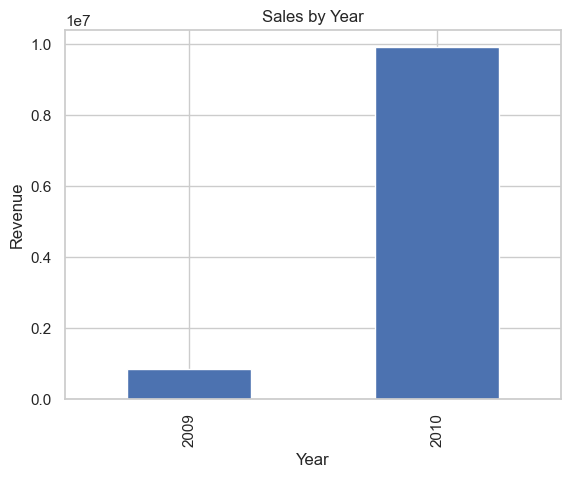

In [333]:
retail_data.groupby('Year')['Revenue'].sum().plot(kind='bar') 
plt.title('Sales by Year') 
plt.xlabel('Year') 
plt.ylabel('Revenue') 
plt.show()

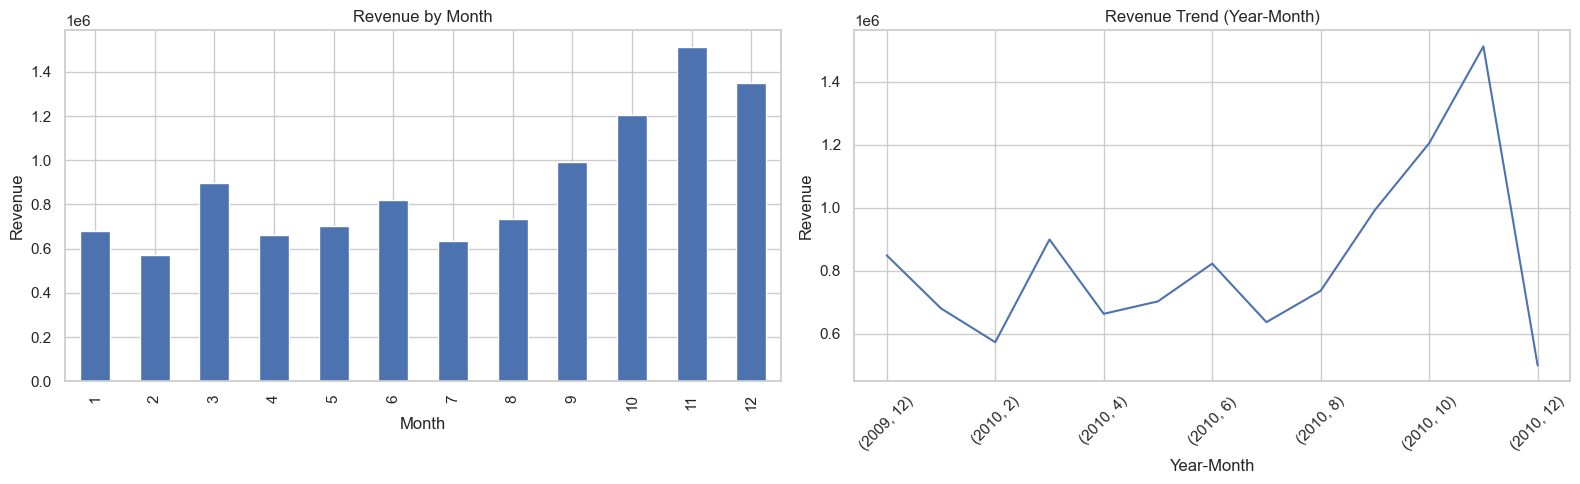

In [334]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

retail_data.groupby('Month')['Revenue'].sum().plot(
    kind='bar',
    ax=axes[0]
)
axes[0].set_title('Revenue by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')

retail_data.groupby(['Year','Month'])['Revenue'].sum().plot(
    ax=axes[1]
)
axes[1].set_title('Revenue Trend (Year-Month)')
axes[1].set_xlabel('Year-Month')
axes[1].set_ylabel('Revenue')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

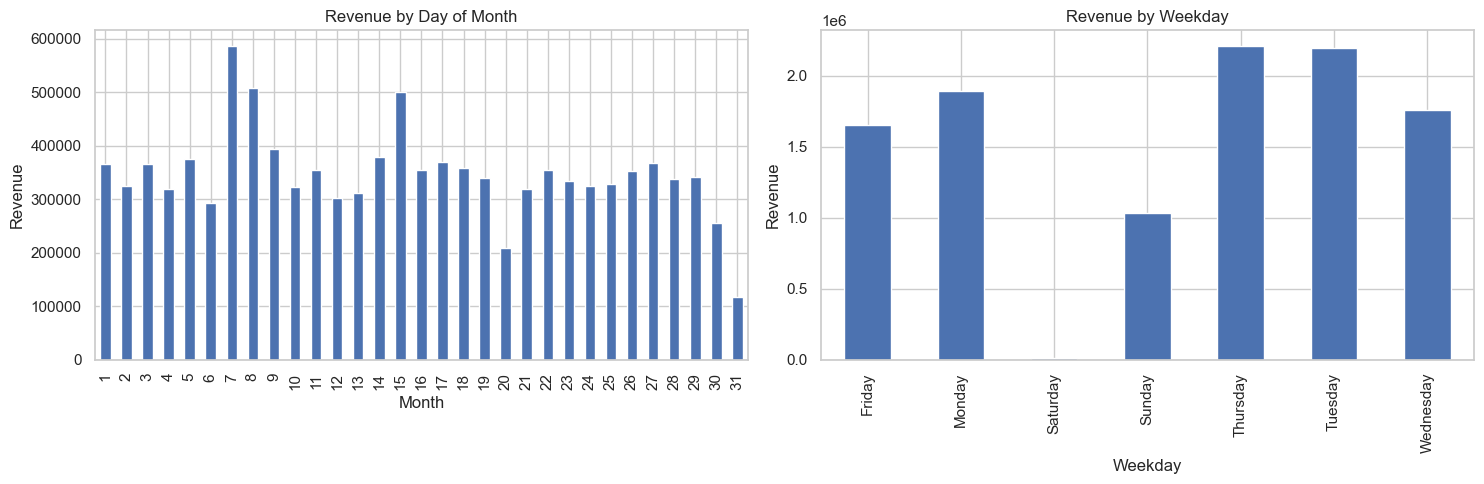

In [335]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

retail_data.groupby('Day')['Revenue'].sum().plot(
    kind='bar',
    ax=axes[0]
)
axes[0].set_title('Revenue by Day of Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')

retail_data.groupby('Weekday')['Revenue'].sum().plot(
    kind='bar',
    ax=axes[1]
)
axes[1].set_title('Revenue by Weekday')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Revenue')

plt.tight_layout()
plt.show()

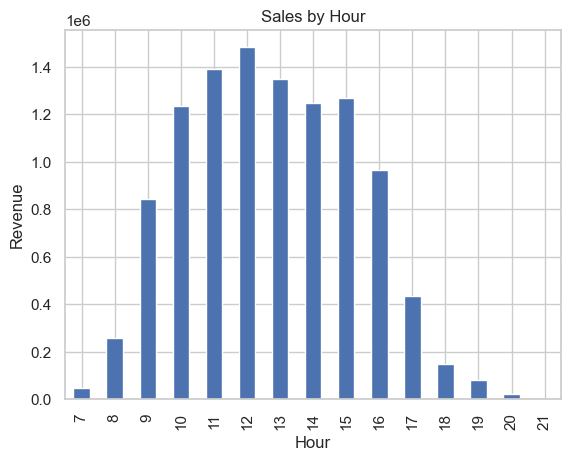

In [336]:
retail_data.groupby('Hour')['Revenue'].sum().plot(kind='bar')
plt.title('Sales by Hour')
plt.xlabel('Hour')
plt.ylabel('Revenue')
plt.show()


In [337]:
retail_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue,Year,Month,Day,Hour,Weekday
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Sale,83.4,2009,12,1,7,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Sale,81.0,2009,12,1,7,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Sale,81.0,2009,12,1,7,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Sale,100.8,2009,12,1,7,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Sale,30.0,2009,12,1,7,Tuesday


# now that we'done with the sales analysis and EDA:
    1.  We're gonna Drop the negative one from the customer ID and then group the customers by their IDs so we can do RFM analysis
    2.  We're gonna handle the description by groping the products with their stock code and then giving them the same description and also so we can get the best  sold products and the least sold ones

In [338]:
sales_data = retail_data[retail_data['TransactionType'] == 'Sale']
sales_data = sales_data[sales_data['Customer ID'] != -1]
sales_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue,Year,Month,Day,Hour,Weekday
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,Sale,83.4,2009,12,1,7,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Sale,81.0,2009,12,1,7,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,Sale,81.0,2009,12,1,7,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,Sale,100.8,2009,12,1,7,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,Sale,30.0,2009,12,1,7,Tuesday


In [339]:
snapshot_date = sales_data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = sales_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'count',  
    'Revenue': 'sum'       
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,165,33,372.86
1,12347.0,3,71,1323.32
2,12348.0,74,20,222.16
3,12349.0,43,102,2671.14
4,12351.0,11,21,300.93


In [340]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [341]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine to single RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,165,33,372.86,2,3,2,232
1,12347.0,3,71,1323.32,5,4,4,544
2,12348.0,74,20,222.16,2,2,1,221
3,12349.0,43,102,2671.14,3,4,5,345
4,12351.0,11,21,300.93,5,2,2,522


In [342]:
def rfm_segment(df):
    rfm_score = int(df['RFM_Score'])
    
    if rfm_score >= 444:  
        return 'Champions/Best'
    elif rfm_score >= 333:
        return 'Loyal'
    elif rfm_score >= 222:
        return 'Potential'
    else:
        return 'Needs Attention'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

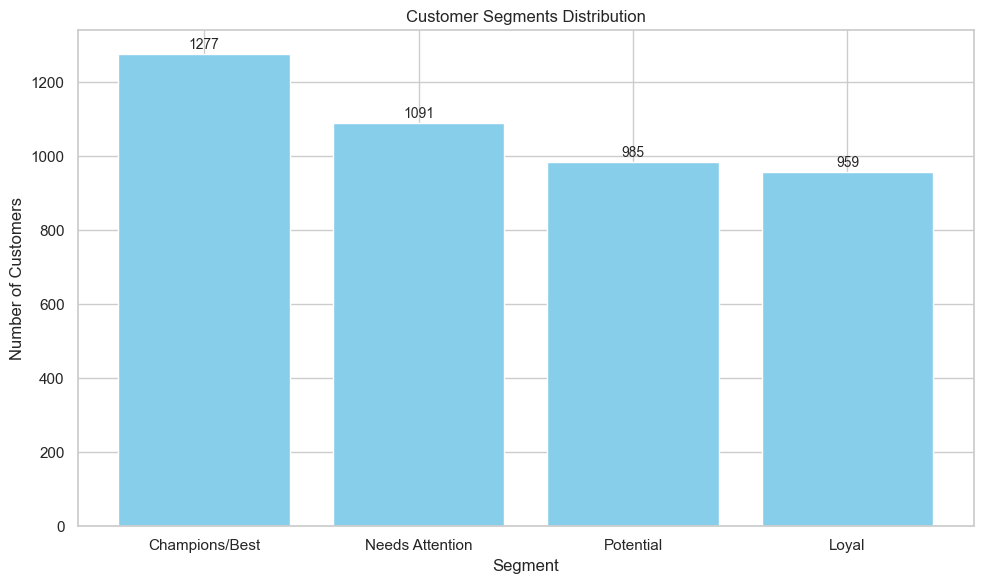

Segment Distribution (%):
Segment
Champions/Best     29.615028
Needs Attention    25.301484
Potential          22.843228
Loyal              22.240260
Name: proportion, dtype: float64%


In [383]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(segment_counts.index, segment_counts.values, color='skyblue')

# Add counts above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5,  # small offset above the bar
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Percentage distribution
segment_pct = rfm['Segment'].value_counts(normalize=True) * 100
print("Segment Distribution (%):")
print(f"{segment_pct}%")


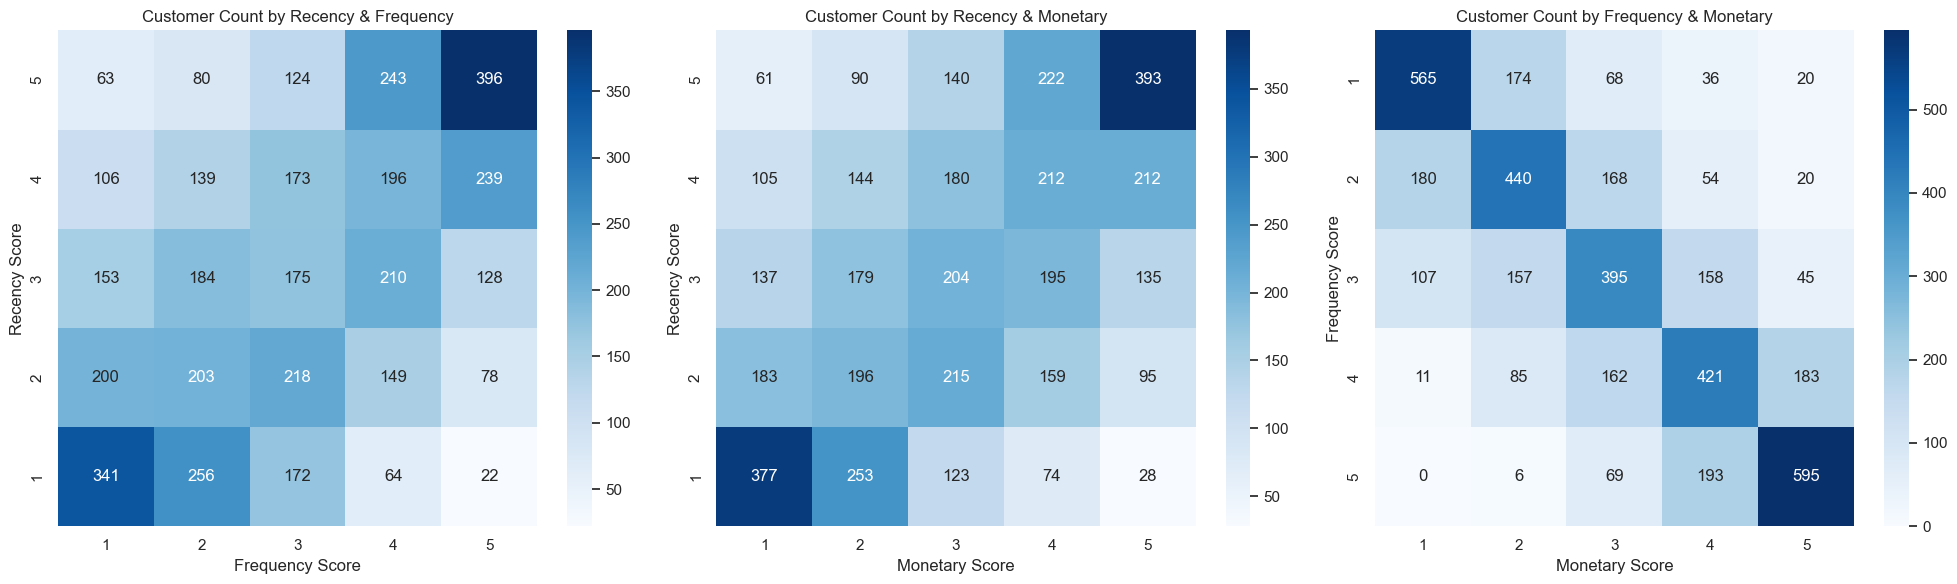

In [344]:
rfm_r_f_count = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='count', observed=False)
rfm_r_m_count = rfm.pivot_table(index='R_Score', columns='M_Score', values='Frequency', aggfunc='count', observed=False)
rfm_f_m_count = rfm.pivot_table(index='F_Score', columns='M_Score', values='Recency', aggfunc='count', observed=False)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(rfm_r_f_count, annot=True, fmt=".0f", cmap='Blues', ax=axes[0])
axes[0].set_title('Customer Count by Recency & Frequency')
axes[0].set_xlabel('Frequency Score')
axes[0].set_ylabel('Recency Score')

sns.heatmap(rfm_r_m_count, annot=True, fmt=".0f", cmap='Blues', ax=axes[1])
axes[1].set_title('Customer Count by Recency & Monetary')
axes[1].set_xlabel('Monetary Score')
axes[1].set_ylabel('Recency Score')

sns.heatmap(rfm_f_m_count, annot=True, fmt=".0f", cmap='Blues', ax=axes[2])
axes[2].set_title('Customer Count by Frequency & Monetary')
axes[2].set_xlabel('Monetary Score')
axes[2].set_ylabel('Frequency Score')

plt.tight_layout()
plt.show()

In [345]:
def plot_customers(df, title, palette):
    plt.figure(figsize=(12,6))
    bars = sns.barplot(x='Customer ID', y='Frequency', data=df, palette=palette,hue='Customer ID',legend=False)
    
    for bar in bars.patches:
        height = bar.get_height()
        bars.annotate(f'{int(height)}', 
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 5),  
                      textcoords='offset points',
                      ha='center', va='bottom', fontsize=10)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Customer ID', fontsize=12)
    plt.ylabel('Number of Purchases', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


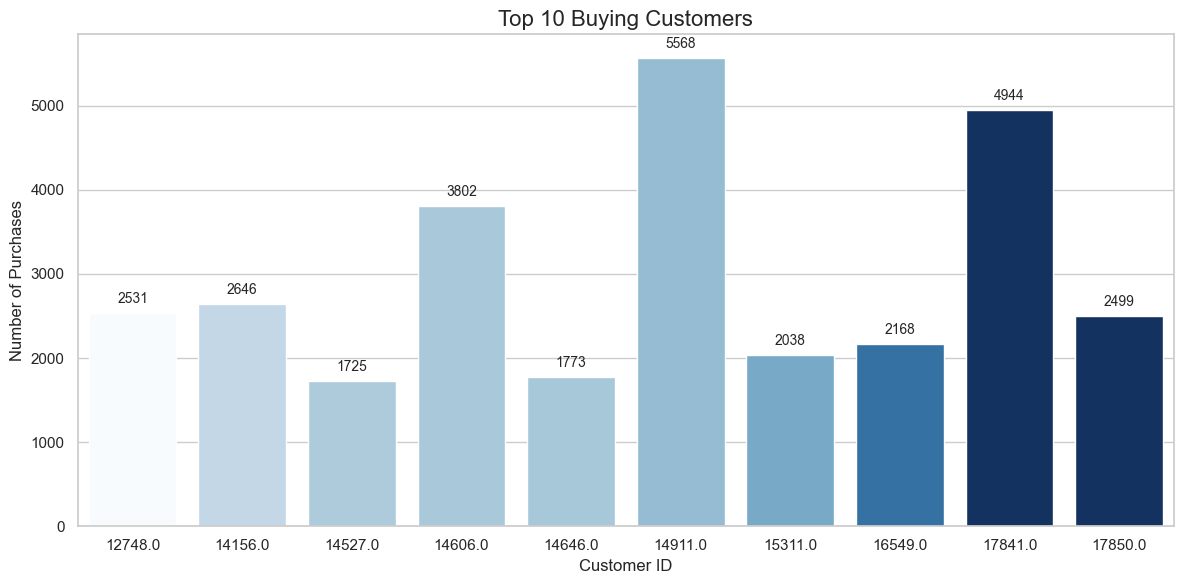

In [346]:
best_customers = rfm[rfm['Segment'] == 'Champions/Best'].sort_values('Monetary', ascending=False)

top_10 = best_customers.nlargest(10, 'Frequency')
plot_customers(top_10, 'Top 10 Buying Customers', palette='Blues')



In [396]:
retail_data[(retail_data['Customer ID'] == 14911.0 ) & (retail_data['TransactionType'] == 'Sale')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue,Year,Month,Day,Hour,Weekday
440,489520,35751C,PURPLE CURRENT CANDLE RING,12,2009-12-01 11:41:00,0.75,14911.0,EIRE,Sale,9.00,2009,12,1,11,Tuesday
441,489520,72739B,WHITE CHOCOLATE SCENT CANDLE,12,2009-12-01 11:41:00,1.25,14911.0,EIRE,Sale,15.00,2009,12,1,11,Tuesday
442,489520,22114,HOT WATER BOTTLE TEA AND SYMPATHY,8,2009-12-01 11:41:00,3.95,14911.0,EIRE,Sale,31.60,2009,12,1,11,Tuesday
443,489520,22212,FOUR HOOK WHITE LOVEBIRDS,6,2009-12-01 11:41:00,2.10,14911.0,EIRE,Sale,12.60,2009,12,1,11,Tuesday
444,489520,21523,FANCY FONT HOME SWEET HOME DOORMAT,2,2009-12-01 11:41:00,6.75,14911.0,EIRE,Sale,13.50,2009,12,1,11,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523021,538009,21754,HOME BUILDING BLOCK WORD,3,2010-12-09 12:17:00,5.95,14911.0,EIRE,Sale,17.85,2010,12,9,12,Thursday
523022,538009,22840,ROUND CAKE TIN VINTAGE RED,2,2010-12-09 12:17:00,7.95,14911.0,EIRE,Sale,15.90,2010,12,9,12,Thursday
523023,538009,22842,BISCUIT TIN VINTAGE RED,2,2010-12-09 12:17:00,6.75,14911.0,EIRE,Sale,13.50,2010,12,9,12,Thursday
523024,538009,22197,SMALL POPCORN HOLDER,36,2010-12-09 12:17:00,0.85,14911.0,EIRE,Sale,30.60,2010,12,9,12,Thursday


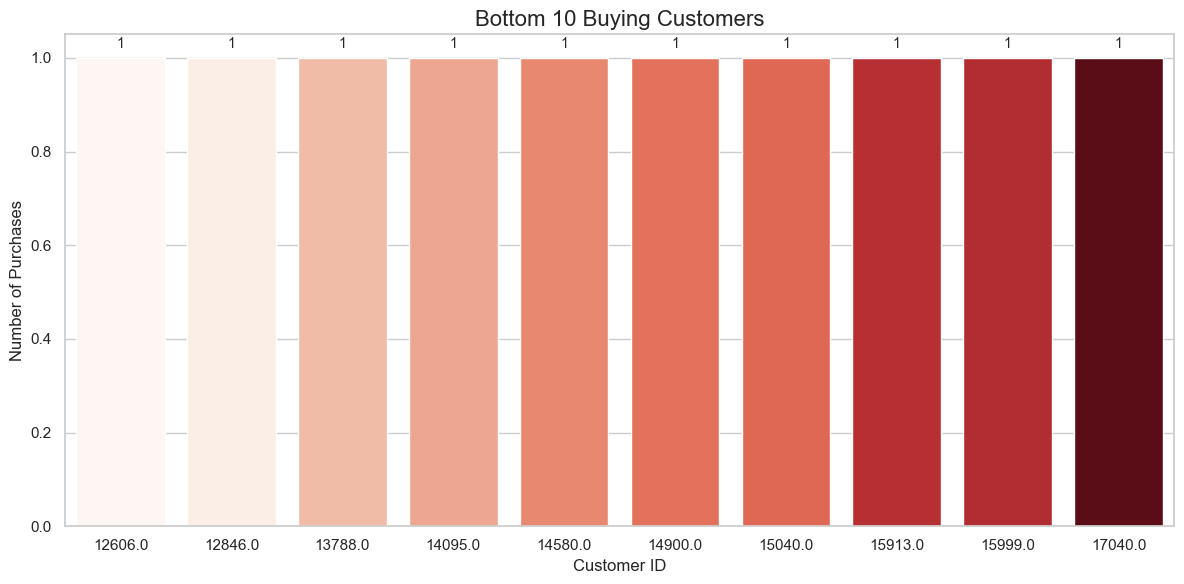

In [347]:
bottom_customers = rfm[rfm['Segment'] == 'Needs Attention'].sort_values('Monetary', ascending=True)

bottom_10 = bottom_customers.nsmallest(10, 'Frequency')
plot_customers(bottom_10, 'Bottom 10 Buying Customers', palette='Reds')


# getting the most & the Least sold products:
    1.  we're gonna group by the products the have the same  stock code and description
    2.  we're gonna get the sum of the quantity & revenue for them so we'd see wich product is being sold more and which is being sold less
    3.  we're gonna get the records of the sales on it's own and the records of the refunds and cancellations on it's own so we'd know which produscts are being sold more and less, and also which products are the being refunded back to us the most.
    4.  and now that we care about the products we'gonna drop the Unkown products


In [373]:
retail_data = retail_data[retail_data['Description'] != "Unknown"]
sales_df = retail_data[retail_data['TransactionType'] == 'Sale']

sales_grouped = (
    sales_df.groupby(['StockCode','Description'])['Quantity']
    .sum()
    .reset_index()
    .sort_values('Quantity', ascending=False)
)

top_sold = sales_grouped.head(10)
least_sold = sales_grouped.tail(10)


In [400]:
sales_grouped

,StockCode,Description,Quantity
4271,85123A,WHITE HANGING HEART T-LIGHT HOLDER,58386
2722,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54947
52,17003,BROCADE RING PURSE,48374
533,21212,PACK OF 72 RETRO SPOT CAKE CASES,46728
2892,84879,ASSORTED COLOUR BIRD ORNAMENT,45228
...,...,...,...
3678,79151B,"SILICON CUBE 25W, BLUE",1
4169,84997d,PINK 3 PIECE MINI DOTS CUTLERY SET,1
3286,30086C,ASSORTED FRUIT STRAWS,1
3679,79157B,UBO-LIGHT TRIOBASE BLUE,1


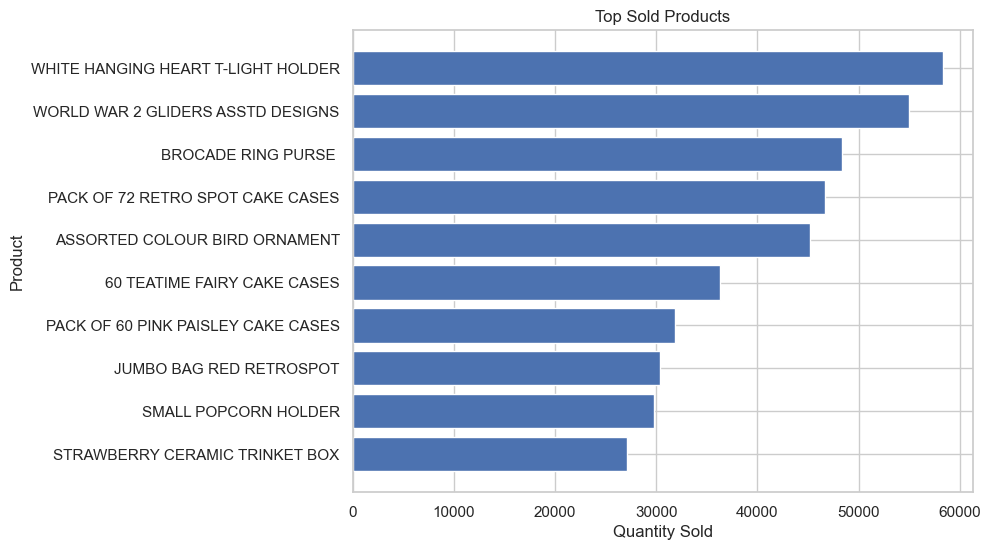

In [374]:
plt.figure(figsize=(8,6))
plt.barh(top_sold['Description'], top_sold['Quantity'])
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.title("Top Sold Products")
plt.gca().invert_yaxis()  
plt.show()

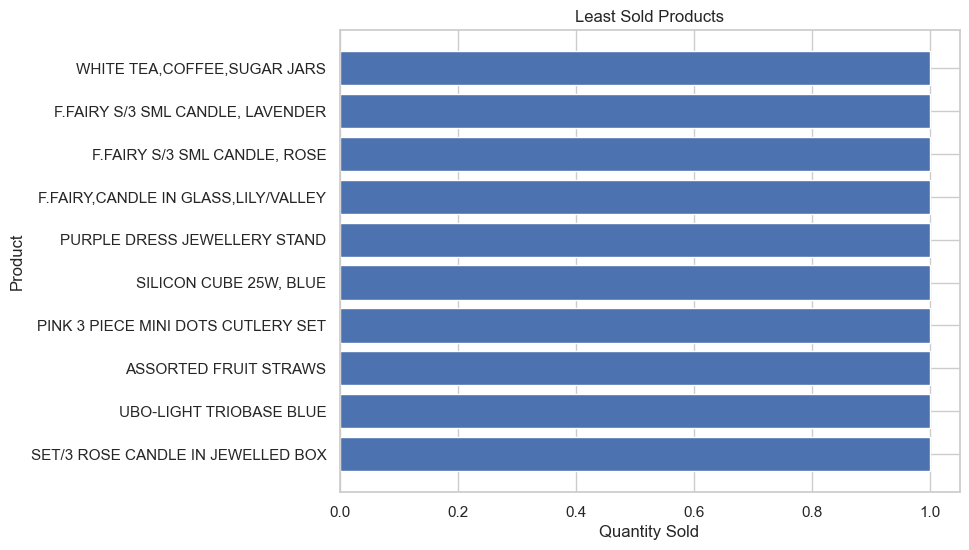

In [375]:
plt.figure(figsize=(8,6))
plt.barh(least_sold['Description'], least_sold['Quantity'])
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.title("Least Sold Products")
plt.gca().invert_yaxis()  
plt.show()

In [376]:
return_types = ['Refunded', 'Anomaly_Refund', 'Cancelled_Completed', 'Cancelled_Requested']

returned_products = pd.DataFrame()

for t in return_types:
    tmp = retail_data[retail_data['TransactionType'] == t].copy()
    
    tmp['Quantity'] = tmp['Quantity'].abs()
    
    tmp_grouped = tmp.groupby(['StockCode', 'Description']).agg({
        'Quantity': 'sum',
        'Revenue': 'sum'  
    }).reset_index()
    
    tmp_grouped['ReturnType'] = t
    returned_products = pd.concat([returned_products, tmp_grouped], ignore_index=True)

top_returned = returned_products.sort_values('Quantity', ascending=False).head(20)


In [401]:
top_returned

,StockCode,Description,Quantity,Revenue,ReturnType
144,84016,ebay sales,13500,0.00,Cancelled_Completed
75,22126,given away,10000,0.00,Cancelled_Completed
19,20852,given away,10000,0.00,Cancelled_Completed
1890,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9374,312.60,Cancelled_Requested
0,10120,Zebra invcing error,9000,0.00,Cancelled_Completed
2,16235,?,9000,0.00,Cancelled_Completed
18,20852,Given away,8800,0.00,Cancelled_Completed
512,21088,SET/6 FRUIT SALAD PAPER CUPS,7128,570.24,Cancelled_Requested
143,84016,Ebay sales by the box.,7100,0.00,Cancelled_Completed
515,21096,SET/6 FRUIT SALAD PAPER PLATES,7008,911.04,Cancelled_Requested


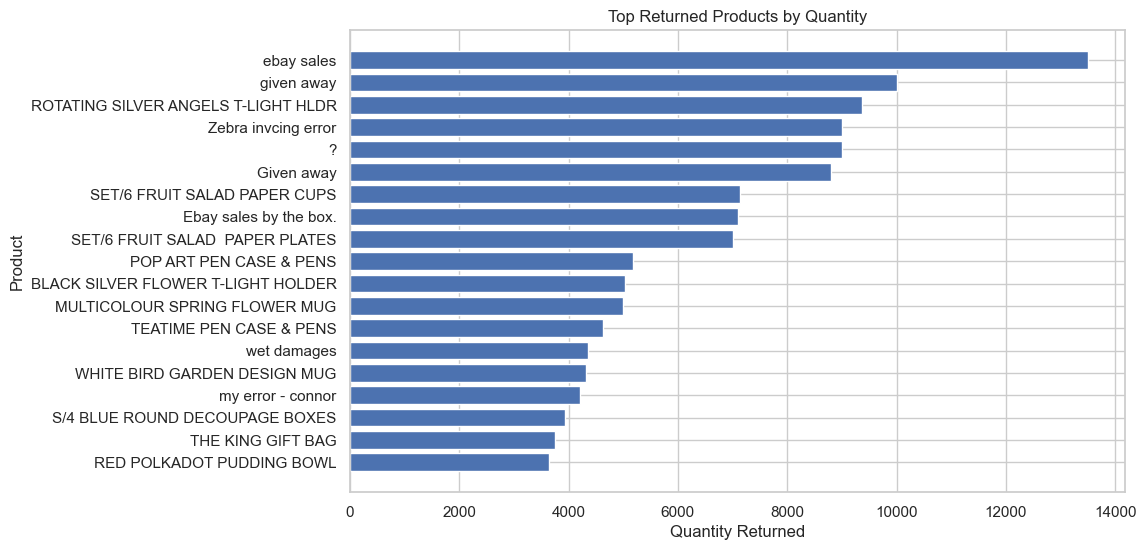

In [377]:
plt.figure(figsize=(10,6))
plt.barh(top_returned['Description'], top_returned['Quantity'])
plt.xlabel('Quantity Returned')
plt.ylabel('Product')
plt.title('Top Returned Products by Quantity')
plt.gca().invert_yaxis()  
plt.show()

In [379]:
retail_data[retail_data['Quantity'] == retail_data['Quantity'].min()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue,Year,Month,Day,Hour,Weekday
507225,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,Cancelled_Requested,280.8,2010,12,2,14,Thursday


In [380]:
retail_data[retail_data['Description'] == 'ebay sales']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TransactionType,Revenue,Year,Month,Day,Hour,Weekday
114238,500321,84016,ebay sales,-3300,2010-03-07 12:03:00,0.0,-1.0,United Kingdom,Cancelled_Completed,0.0,2010,3,7,12,Sunday
136409,502457,84016,ebay sales,-5200,2010-03-24 14:20:00,0.0,-1.0,United Kingdom,Cancelled_Completed,0.0,2010,3,24,14,Wednesday
136410,502458,84016,ebay sales,-5000,2010-03-24 14:21:00,0.0,-1.0,United Kingdom,Cancelled_Completed,0.0,2010,3,24,14,Wednesday
184701,506975,45016,ebay sales,-130,2010-05-05 12:44:00,0.0,-1.0,United Kingdom,Cancelled_Completed,0.0,2010,5,5,12,Wednesday
